In [14]:
import os.path as op
from scipy.io import loadmat
import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns


subject = '01'

root_folder = '/data/ds-riskeye'

In [15]:
source_folder = op.join(root_folder, 'sourcedata')

def load_behavior(fn):
    data = loadmat(fn, squeeze_me=True, simplify_cells=True)['magRiskTrial']

    fields = ['accuracy', 'rt', 'leftRight', 'pressedKey', 's1_perm', 's2_perm', 'constSide', 'correct_perm', 'reset', 'stimOnset']
    data = pd.DataFrame(dict((k, data[k]) for k in fields))

    return data

reg = re.compile(f'.*/sub_{subject}_run_(?P<run>[0-9]+).+riskComp_(?P<task>[0-9]+)_taskSeq_(?P<block>[0-9]+)\.mat')

fns = sorted(glob.glob(op.join(source_folder, f'sub_{subject}*', f'sub_{subject}*resPar_02_riskComp_*_taskSeq_*.mat')))

df =  []
keys = []
for fn in fns:
    df.append(load_behavior(fn))
    info = reg.match(fn).groupdict()
    keys.append((f'{int(subject):02d}', int(info['run']), int(info['task']), int(info['block'])))

df = pd.concat(df, keys=keys, names=['subject', 'run', 'exptype', 'block']).droplevel(-1)
df['trial'] = df.groupby(['subject', 'run', 'block']).cumcount() + 1
df.set_index('trial', append=True, inplace=True)

df = df.rename(columns={'s1_perm':'n_safe', 's2_perm':'n_risky', 'stimOnset':'onset'})
df['onset'] /= 1000.
df['rt'] /= 1000.

df.reset_index(inplace=True)
df['exptype'] = df['exptype'].map({2:'symbolic', 3:'non-symbolic'})
df.set_index(['subject', 'run', 'exptype', 'block', 'trial'], inplace=True)

reset1 = df.reset == 1

# When reset == 1, the sure bet is on the left
df['n_left'] = df['n_safe'].where(reset1, df['n_risky']) # ok
df['n_right'] = df['n_risky'].where(reset1, df['n_safe']) # ok
df['p_left'] = df['p_right'] = 1.0 # ok
df['p_left'] = df['p_left'].where(reset1, .55) # ok
df['p_right'] = df['p_right'].where(~reset1, .55) # ok

df['chose_risky'] = (((df['leftRight'] == 1) & (df['reset'] == -1)) | ((df['leftRight'] == -1) & (df['reset'] == 1))).astype(float)
df.loc[~np.in1d(df.leftRight, [-1, 1]), 'chose_risky'] = np.nan

df['log(risky/safe)'] = np.log(df['n_risky'] / df['n_safe'])


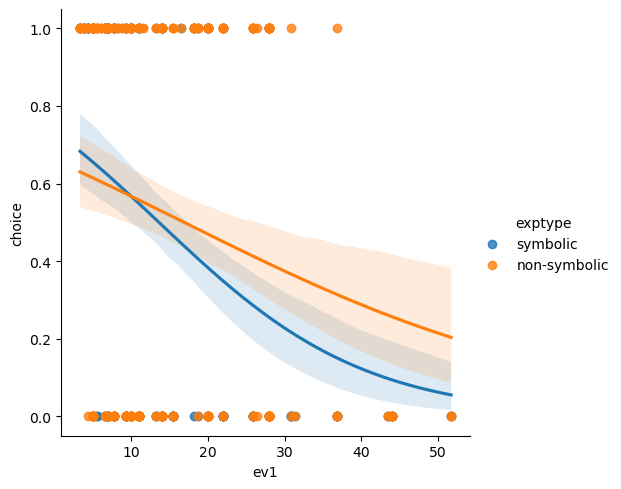

In [22]:
df['ev1'] = df['n_left'] * df['p_left']
df['ev2'] = df['n_right'] * df['p_right']
df['choice'] = df['leftRight'] == -1


sns.lmplot(data=df.reset_index(), x='ev1', y='choice', hue='exptype', logistic=True)

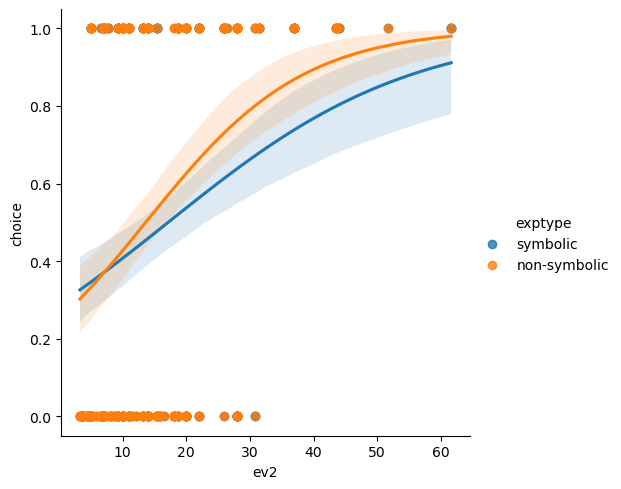

In [23]:
sns.lmplot(data=df.reset_index(), x='ev2', y='choice', hue='exptype', logistic=True)

In [5]:
import seaborn as sns

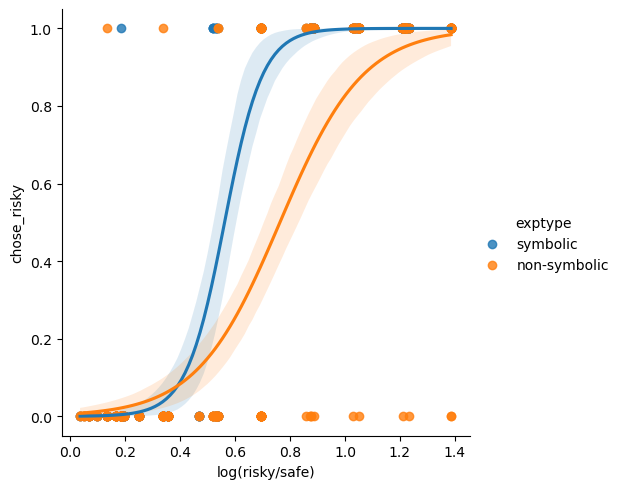

In [8]:
sns.lmplot(data=df.reset_index(), x='log(risky/safe)', y='chose_risky', hue='exptype', logistic=True)